<a href="https://colab.research.google.com/github/YK1218/CKD-FINAL/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from transformers import pipeline
from collections import defaultdict
import re
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')


emotion_pipe = pipeline("text-classification", model="monologg/bert-base-cased-goemotions-original", return_all_scores=True)

text = "I feel like she doesn’t want to be with me. That really hurts."

# Get all GoEmotions scores
results = emotion_pipe(text)[0]

# Map to your 6 emotions
emotion_map = {
    'anxiety': ['fear', 'nervousness', 'worry'],
    'sadness': ['sadness', 'disappointment'],
    'anger': ['anger', 'annoyance', 'frustration'],
    'guilt': ['guilt', 'remorse'],
    'shame': ['embarrassment', 'shame'],
    'hope': ['optimism', 'excitement']
}

# Sum scores for mapped emotions
from collections import defaultdict

final_scores = defaultdict(float)
for item in results:
    for category, labels in emotion_map.items():
        if item['label'] in labels:
            final_scores[category] += item['score']

# Print sorted results
for emotion, score in sorted(final_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{emotion.capitalize()}: {round(score, 3)}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.67k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/235 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/182 [00:00<?, ?B/s]

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Sadness: 0.999
Anger: 0.0
Anxiety: 0.0
Hope: 0.0
Guilt: 0.0
Shame: 0.0


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


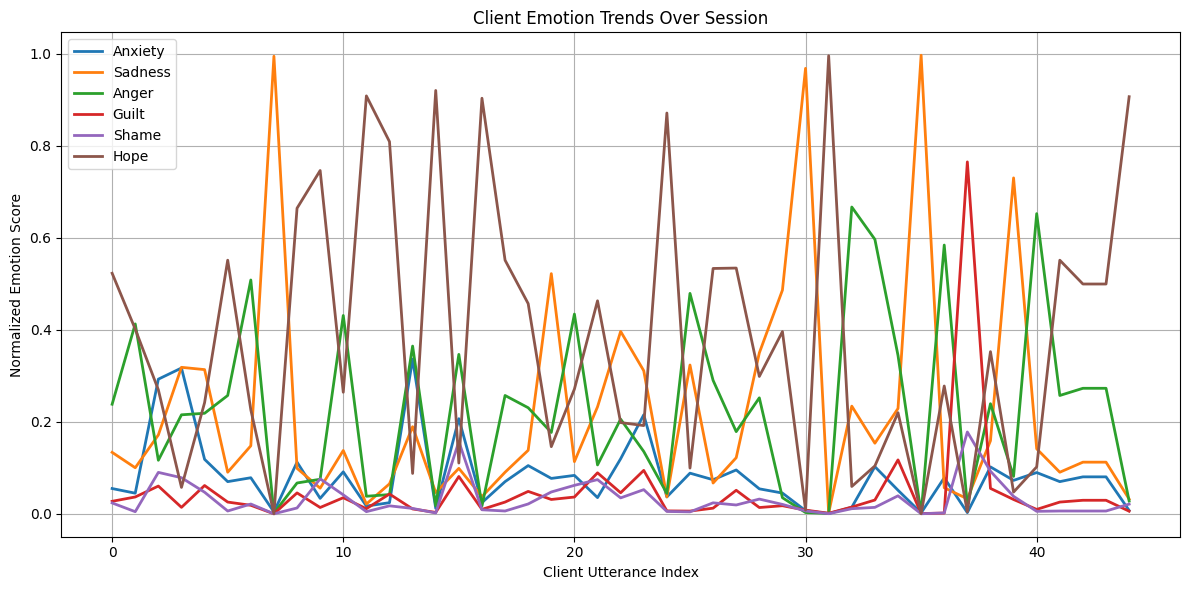

In [2]:
def preprocess_transcript(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        content = file.readlines()

    client_lines = []
    for line in content:
        line = line.strip()
        if line.startswith("C:"):
            sentence = line[2:].strip()
            if sentence:
                client_lines.append(sentence)
    return client_lines

# Helper: Classify emotions
def classify_emotions(lines):
    emotion_over_time = {e: [] for e in emotion_map.keys()}

    for line in lines:
        raw_results = emotion_pipe(line)[0]
        scores = defaultdict(float)

        # Map GoEmotions to 6 custom emotions
        for item in raw_results:
            for key, group in emotion_map.items():
                if item['label'] in group:
                    scores[key] += item['score']

        # Normalize to sum = 1 (optional)
        total = sum(scores.values())
        if total > 0:
            for key in scores:
                scores[key] /= total

        # Append scores for each emotion
        for emotion in emotion_map.keys():
            emotion_over_time[emotion].append(scores.get(emotion, 0.0))

    return emotion_over_time

# Helper: Plot line graph of emotions
def plot_emotions(emotion_scores):
    plt.figure(figsize=(12, 6))
    for emotion, scores in emotion_scores.items():
        plt.plot(scores, label=emotion.capitalize(), linewidth=2)

    plt.title("Client Emotion Trends Over Session")
    plt.xlabel("Client Utterance Index")
    plt.ylabel("Normalized Emotion Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Run the full analysis ===
transcript_path = "/content/drive/MyDrive/Colab Notebooks/cleaned_transcript.txt"  # Make sure this file follows the C: format
client_lines = preprocess_transcript(transcript_path)
emotion_data = classify_emotions(client_lines)
plot_emotions(emotion_data)

In [3]:
import numpy as np

def plot_emotions_spider(emotion_scores):
    # Calculate average emotion score across all client lines
    labels = list(emotion_scores.keys())
    averages = [np.mean(emotion_scores[emotion]) for emotion in labels]

    # Close the plot circle
    values = averages + [averages[0]]
    labels = labels + [labels[0]]

    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=True)

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    ax.plot(angles, values, 'b-', linewidth=2)
    ax.fill(angles, values, 'skyblue', alpha=0.4)
    ax.set_yticklabels([])
    ax.set_xticks(angles)
    ax.set_xticklabels([label.capitalize() for label in labels])
    ax.set_title("🕸️ Average Client Emotion Profile (Spider Graph)", size=15)
    plt.tight_layout()
    plt.show()

<ipython-input-3-c230d44d9a8d>:21: UserWarning: Glyph 128376 (\N{SPIDER WEB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128376 (\N{SPIDER WEB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


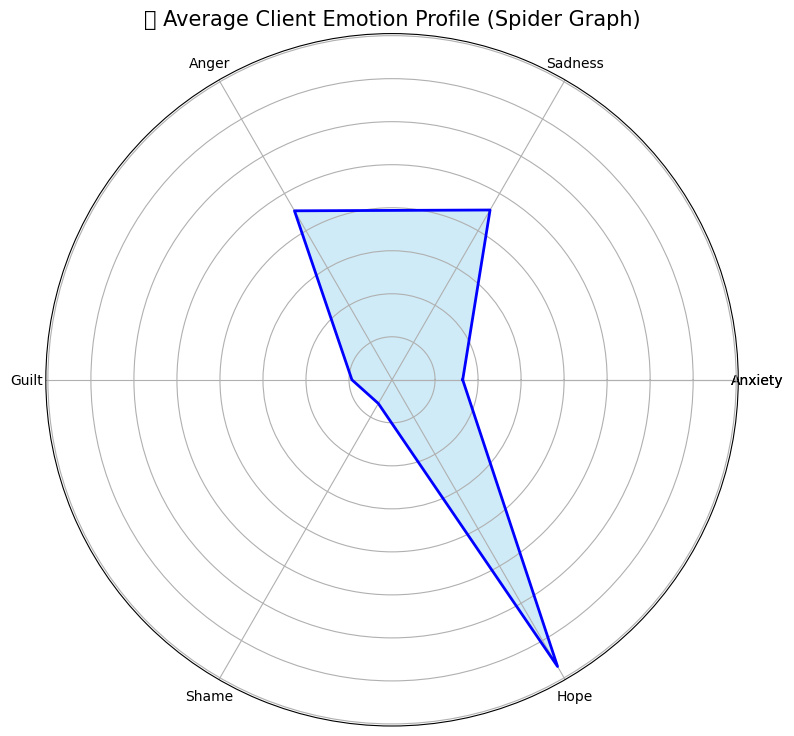

In [4]:
plot_emotions_spider(emotion_data)

In [25]:
#summerizer
# Load summarization model (you can switch to more powerful ones if needed)
# summarizer_news_style = pipeline("summarization", model="facebook/bart-large-cnn")
summarizero1 = pipeline("summarization", model="philschmid/bart-large-cnn-samsum")
summarizero2 = pipeline("summarization", model="google/pegasus-cnn_dailymail")


Device set to use cuda:0
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0


In [26]:
def summarize_client_text(client_lines, chunk_size=500):
    """
    Summarizes the entire client conversation. Automatically chunks if it's too long.
    """
    text = " ".join(client_lines)
    summaries = []

    # Break into chunks if text is too long
    for i in range(0, len(text), chunk_size):
        chunk = text[i:i+chunk_size]
        result = summarizero2(chunk, max_length=130, min_length=30, do_sample=False)
        summaries.append(result[0]['summary_text'])

    return " ".join(summaries)


In [27]:
# 📄 Generate client summary
summary = summarize_client_text(client_lines)
print("\n📝 Summary of Client's Conversation:\n")
print(summary)

Your max_length is set to 130, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)



📝 Summary of Client's Conversation:

Is this yours or is it .<n>I kind of wanted to start with a part of the dream that I had last night.<n>Um, it's been No in reality it does but there's something wrong with the headlights.<n>Which means that he can't drive at night so what he does is that sometimes he . This is an area where I'm not My experiences with it probably .<n>I feel like deep down he wants to spend more time with me .<n>This is an area where I'm not My experiences with it probably . Despite how much in love with me he becomes .<n>Despite how much in love with me he becomes .<n>Despite how much in love with me he becomes A really fortunate pan of my experience with him is thar he's the My Tetley tea man .<n>I don't know why he (inaudible) I mean... He left me a note . I feel like I have some control over my life and I would like to plan it I don't .<n>I get my work done so I don't need to feel guilty.<n>And I am aware that I am going to get it done. But, you know, in the con

In [28]:
!pip install openai

In [40]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import pipeline


In [41]:
# Load the DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
summarizer03 = pipeline("summarization", model="facebook/bart-large-cnn")


Device set to use cuda:0


In [44]:
def summarize_client_text(client_lines, chunk_size=500):
    """
    Summarizes the entire client conversation. Automatically chunks if it's too long.
    """
    text = " ".join(client_lines)
    summaries = []

    # Break into chunks if text is too long
    for i in range(0, len(text), chunk_size):
        chunk = text[i:i+chunk_size]
        result = summarizer03(chunk, max_length=130, min_length=30, do_sample=False)
        summaries.append(result[0]['summary_text'])

    return " ".join(summaries)

In [45]:
# 📄 Generate client summary
summary = summarize_client_text(client_lines)
print("\n📝 Summary of Client's Conversation:\n")
print(summary)

Your max_length is set to 130, but your input_length is only 121. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)
Your max_length is set to 130, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)
Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)



📝 Summary of Client's Conversation:

"There's something wrong with the headlights. Something with the electrical system keeps them working at night Yeah. Which means that he can't drive at night" "I really feel like deep down he wants to spend more time with me. I don't.. Yeah. So I think that's probably my . . . This is an area where I'm not My experiences with it probably s It was pretty clear to me that he really enjoyed me. He wanted to spend time with me as much as we both could. Despite how much in love with me he becomes. "I'm I was really into enjoying him very much. And so I got this message from him, "I don't think I'm going to be spending as much" "I think that he might be looking at this more in terms of not enjoying me for now" "Because I feel like I have some control over my life and I would like to plan it I don't. one time, you know, signed your Tetley tea man," she said. "Here's a pan of me that wanted to convince him to like me. You know, um . . . Yeah. Yeah Yeah"
